# <div align='center'> **Predicting Salaries**


<div align='center'> December 5th, 2023

**Brigham Young University**

```
Sophie Carter
Morgan Nielsen 
Michelle Wang
Sarah Winters
```

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from itertools import combinations
import statsmodels.api as sm
from sklearn import linear_model
import us
from us import states

## **1 &ensp; Introduction**

### **1.1 &ensp; Background**


### **1.2 &ensp; Motivation**

### **1.3 &ensp; Overview**

&emsp; &nbsp; We had three main questions that we wanted to answer throughout this paper. First, we wanted to determine if our dataset could help us create a model to predict the formatted experience level based on the minimum and maximum salaries. We also wanted to observe the other way around—how our model can predict salary ranges based on information like location, experience level, and description. Finally, we wanted to determine common words in job descriptions and necessary skills, to be able to determine entry-level jobs; our greatest interest here is specifically in entry-level jobs, since in our personal job hunting experiences, we have run across job descriptions that contradict the formatted experience level. 


## **2 &ensp; The Data**

### **2.1 &ensp; Data Description**

&emsp; &nbsp; Originally, we were going to use two datasets—one about underemployment and one that included LinkedIn job postings from 2023. However, we realized after our proposal and looking more closely at the data that the underemployment dataset wouldn’t be very relevant with the information we could extract from the second dataset. The LinkedIn dataset is a record of over 33,000 job postings spread out between two separate days in 2023 that are months apart. The dataset includes 27 features total, though we mostly used minimum salary, maximum salary, formatted experience level, job description, location, and necessary skills listed. 

### **2.2 &ensp; Data Preparation**

&emsp; &nbsp; Unfortunately, many features in the dataset have hundreds or thousands of NaN values. To observe which columns had the most missing data, we used the pandas feature “.isna().sum()” to observe the list of features and the number of missing values listed for each. 

In [2]:
job_postings_data = pd.read_csv('job_postings.csv')

In [3]:
# look at the missing data
missing_data = job_postings_data.isna().sum()
print(missing_data)

job_id                            0
company_id                      366
title                             0
description                       1
max_salary                    10365
med_salary                    14905
min_salary                    10365
pay_period                     9384
formatted_work_type               0
location                          0
applies                        7186
original_listed_time              0
remote_allowed                13546
views                          2763
job_posting_url                   0
application_url                6091
application_type                  0
expiry                            0
closed_time                   14958
formatted_experience_level     4902
skills_desc                   15742
listed_time                       0
posting_domain                 6842
sponsored                         0
work_type                         0
currency                       9384
compensation_type              9384
dtype: int64


In [4]:
job_postings_data = job_postings_data[job_postings_data['description'].notna()]

# now drop the max, min salaries with NaN values
job_postings_data = job_postings_data[job_postings_data['max_salary'].notna()]

# drop the missing formatted experience data
job_postings_data = job_postings_data[job_postings_data['formatted_experience_level'].notna()]
# we only want to look at the salary that's yearly
job_postings_data['pay_period'].value_counts()
job_postings_data['formatted_work_type'].value_counts()

# filter out the data to just be full-time
full_time_mask = job_postings_data['formatted_work_type'] == 'Full-time'
full_time_data = job_postings_data[full_time_mask]
# print(full_time_data['pay_period'].value_counts())

# multiply the monthly max and min salary  by 12
monthly_mask = full_time_data['pay_period'] == 'MONTHLY'
full_time_data.loc[monthly_mask, ['min_salary', 'max_salary']] *= 12

# multiply the hourly data
hourly_mask = full_time_data['pay_period'] == 'HOURLY'
full_time_data.loc[hourly_mask, ['min_salary', 'max_salary']] *= (40 * 52)

# print(full_time_data.columns)

# now observe all the columns that still have missing data
missing_data = full_time_data.isna().sum()
# print(missing_data)

&emsp; &nbsp; Most of the important information for our project goals—specifically minimum and maximum salary, location, and description—had no missing values, which was part of the reason we felt this dataset was adequate for the predictions and observations we were going to make. However, formatted_experience_level had information we wanted, so we decided to drop the rows that had NaN values in this column. 

&emsp; &nbsp; After dropping these values, we also created one-hot encodings for each type of experience level, so we could go through each one and observe the accuracy of our model’s predictions.


## **3 &ensp; Analysis**

### **3.1 &ensp; Predicting Entry Level Jobs based on Min and Max Salary**

In [26]:
# create a df with just the salary
job_postings_data = job_postings_data[job_postings_data['formatted_experience_level'].notna()]
experience_level = job_postings_data[["max_salary", "min_salary"]]

# create our X and y
X = experience_level
y = job_postings_data["formatted_experience_level"]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

predictions = forest_model.predict(X_test)
print(f"RandomForestClassifier Classification: \n {classification_report(y_test, predictions)}")


RandomForestClassifier Classification: 
                   precision    recall  f1-score   support

       Associate       0.37      0.26      0.31       126
        Director       0.50      0.23      0.31        48
     Entry level       0.62      0.56      0.59       215
       Executive       0.00      0.00      0.00         6
      Internship       0.40      0.29      0.33         7
Mid-Senior level       0.63      0.78      0.70       381

        accuracy                           0.59       783
       macro avg       0.42      0.35      0.37       783
    weighted avg       0.57      0.59      0.57       783



I got an error about the classification having multiple classes, so for now, since I mostly care about entry level, I'm going to do a one-hot encoding and just look at entry level

In [27]:
one_hot_data = pd.get_dummies(job_postings_data, columns=['formatted_experience_level'], dtype=int)
# print(one_hot_data.columns)
# split the data
X = one_hot_data[['min_salary', 'max_salary']]
y = one_hot_data['formatted_experience_level_Entry level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

predictions = forest_model.predict(X_test)
print(f"RandomForestClassifier Classification: \n {classification_report(y_test, predictions)}")

RandomForestClassifier Classification: 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       568
           1       0.64      0.50      0.56       215

    accuracy                           0.79       783
   macro avg       0.73      0.70      0.71       783
weighted avg       0.77      0.79      0.78       783



In [28]:
# now run a grid search with different parameters
# 
param_grid = {"n_estimators": [100, 200],
              "max_depth": [4,5,6,7,8],
              "criterion": ['gini', 'entropy']}
forest_grid = GridSearchCV(forest_model, param_grid, scoring='f1')
# run the search
forest_grid.fit(X_train, y_train)
print(f"Best Parameters: {forest_grid.best_params_}\n")
print(f"Best Score: {forest_grid.best_score_}\n")

# predict the labels for the test set
forest_grid_predicted = forest_grid.predict(X_test)
# create the confusion matrix
confusion = confusion_matrix(y_test, forest_grid_predicted)
print(f"Confusion Matrix: \n{confusion}")

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.5582732276132949

Confusion Matrix: 
[[520  48]
 [122  93]]


In [7]:
print(jobs_with_median.columns)

Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type'],
      dtype='object')


I started trying to figure out if having the median salary improved the predictions, but I'm pretty sure dropping the NaN values for both "formatted_experience_level" and "med_salary" gets rid of formatted_experience_level. I'll look more into this later.

In [8]:
# # now look at it with the median salary
# jobs_with_median = jobs_with_median[jobs_with_median['formatted_experience_level'].notna()]
# jobs_with_median = jobs_with_median[jobs_with_median['med_salary'].notna()]

# one_hot_median = pd.get_dummies(jobs_with_median, columns=['formatted_experience_level'], dtype=int)
# print(one_hot_median.columns)
# # split the data
# X = one_hot_median[['min_salary', 'max_salary', 'med_salary']]
# y = one_hot_median['formatted_experience_level_Entry level']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# forest_model = RandomForestClassifier()
# forest_model.fit(X_train, y_train)

# predictions = forest_model.predict(X_test)
# print(f"RandomForestClassifier Classification: \n {classification_report(y_test, predictions)}")


### **3.2 &ensp; Using Salary to Predict Other Experience Levels**

Now I want to see how well salary can predict the other experience levels that aren't entry-level  

In [9]:
# take a few steps back with the data
job_postings_data = pd.read_csv('job_postings.csv')
missing_data = job_postings_data.isna().sum()
# print(missing_data)
job_postings_data = job_postings_data[job_postings_data['description'].notna()]

# now drop the max, min salaries with NaN values
job_postings_data = job_postings_data[job_postings_data['max_salary'].notna()]
# drop the median salary for now-- just since there are so many NaN values
job_postings_data = job_postings_data.drop('med_salary', axis=1)

job_postings_data = job_postings_data[job_postings_data['formatted_experience_level'].notna()]

In [10]:
# create a function for predicting based off of formatted experience level
def experience_level_predictions(experience_level):
    X = one_hot_data[['min_salary', 'max_salary']]
    y = one_hot_data[experience_level]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    forest_model = RandomForestClassifier()
    forest_model.fit(X_train, y_train)

    predictions = forest_model.predict(X_test)

    # now run a grid search with different parameters
    # 
    param_grid = {"n_estimators": [100, 200],
                "max_depth": [4,5,6,7,8],
                "criterion": ['gini', 'entropy']}
    forest_grid = GridSearchCV(forest_model, param_grid, scoring='f1')
    # run the search
    forest_grid.fit(X_train, y_train)
    print(f"Best Parameters: {forest_grid.best_params_}\n")
    print(f"Best Score: {forest_grid.best_score_}\n")

    # predict the labels for the test set
    forest_grid_predicted = forest_grid.predict(X_test)
    # create the confusion matrix
    confusion = confusion_matrix(y_test, forest_grid_predicted)
    print(f"Confusion Matrix: \n{confusion}")

In [44]:
one_hot_data = pd.get_dummies(job_postings_data, columns=['formatted_experience_level'], dtype=int)
print(one_hot_data.columns)


Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'skills_desc', 'listed_time', 'posting_domain',
       'sponsored', 'work_type', 'currency', 'compensation_type',
       'formatted_experience_level_Associate',
       'formatted_experience_level_Director',
       'formatted_experience_level_Entry level',
       'formatted_experience_level_Executive',
       'formatted_experience_level_Internship',
       'formatted_experience_level_Mid-Senior level'],
      dtype='object')


Associate

In [12]:
experience_level_predictions('formatted_experience_level_Associate')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.028829215896885068

Confusion Matrix: 
[[657   0]
 [126   0]]


Director

In [13]:
experience_level_predictions('formatted_experience_level_Director')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.1579668683904884

Confusion Matrix: 
[[731   4]
 [ 42   6]]


Entry level (just for organization's sake)

In [14]:
experience_level_predictions('formatted_experience_level_Entry level')

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.5601229201154567

Confusion Matrix: 
[[518  50]
 [127  88]]


Executive

In [15]:
experience_level_predictions('formatted_experience_level_Executive')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.1096969696969697

Confusion Matrix: 
[[777   0]
 [  6   0]]


Internship

In [16]:
experience_level_predictions('formatted_experience_level_Internship')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.5219047619047619

Confusion Matrix: 
[[775   1]
 [  6   1]]


Mid-Senior Level

In [17]:
experience_level_predictions('formatted_experience_level_Mid-Senior level')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 100}

Best Score: 0.7207973910514729

Confusion Matrix: 
[[267 135]
 [106 275]]


From this, we can conclude that the data makes it so that the best accuracy is predicting mid-senior level jobs, and also that for every experience level, the gini index was the best criterion for our grid search  

### **3.3 &ensp; Predicting Salary Range**

Now, we want to be able to predict the salary range based off of different factors from our data

In [46]:
# split the max_salary data into 5 intervals
max_salary = pd.cut(one_hot_data["max_salary"], 5)
# do the same for the min salary
min_salary = pd.cut(one_hot_data["min_salary"], 5)
# create a pivot table for entry level

# TODO: i'm not even close to finishing this part, but i just wanted to get started. the pandas3 lab is good reference material!

I'm just interested to see a plot of the salaries based on experience level, and then maybe based on locations

In [ ]:
entry_level_data = one_hot_data.groupby('formatted_experience_level_Entry level')
# entry_level_data = entry_level_data.get_group(1).describe
entry_level_data["max_salary"].plot(kind='scatter', color='forestgreen', label='Max Salary of Entry Level')

mid_senior_data = one_hot_data.get_group('formatted_experience_level_Mid-Senior level').describe()
mid_senior_data["max_salary"].plot(kind='scatter', color='limegreen', label='Max Salary of Mid-Senior Level')
plt.legend()

Predicting salary based on different factors available in our data

For the purposes of predicting maximum salary and minimum salary using experience level and location, we continue to clean the data by keeping only the rows with non-null values of max and min salary. We isolate our desired independent variables: 'location' and 'formatted_experience_level.' We then define a function that returns the state given an input location in the format of (city, state), else it returns the city. Since the locations are not identically formatted, there are a few entries that return the city name after passing through the function. We independently map each of these cities to their respective states. We also define a function that, given an input state, returns the respective CONUS region according to the U.S. Department of Labor's Wage and Hour Division's regional divisions: West, Southwest, Midwest, Northeast, and Southeast. We use these functions on the 'location' column in our dataframe to ultimately create a new 'region' column. Our dataframe now has four columns.

In [5]:
full_time_data = full_time_data[full_time_data['max_salary'].notna()]
full_time_data = full_time_data[full_time_data['min_salary'].notna()]

In [6]:
full_time_data

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,expiry,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type
23,2148434586,2780388.0,"Manager, Salesforce Platform",Invitation Homes is a fast-paced evolving publ...,170976.00,NaN,98640.00,YEARLY,Full-time,"New Hampshire, United States",...,1695446273000,NaN,Mid-Senior level,NaN,1692854273000,invitationhomes.wd1.myworkdayjobs.com,0,FULL_TIME,USD,BASE_SALARY
24,2148434616,15564.0,"Lead Solar Maintenance Roofer, Residential Ser...",What to Expect\n The Lead Service Installer wi...,95680.00,NaN,39520.00,HOURLY,Full-time,"San Diego, CA",...,1695446349000,NaN,Mid-Senior level,NaN,1692854349000,www.tesla.com,0,FULL_TIME,USD,BASE_SALARY
27,2148434725,13074.0,Mental Health Professional,"You Belong Here.\nAt MultiCare, we strive to o...",79541.00,NaN,55280.00,YEARLY,Full-time,"Spokane, WA",...,1695447607000,NaN,Entry level,NaN,1692855607000,multicare.wd1.myworkdayjobs.com,0,FULL_TIME,USD,BASE_SALARY
28,2148434726,13074.0,Mental Health Professional,"You Belong Here.\nAt MultiCare, we strive to o...",79541.00,NaN,55280.00,YEARLY,Full-time,"Spokane, WA",...,1695447607000,NaN,Entry level,NaN,1692855607000,multicare.wd1.myworkdayjobs.com,0,FULL_TIME,USD,BASE_SALARY
29,2148434909,6600327.0,Clinic Managers - Physical Therapist,Salary Range: Highly Competitive! - Salary Ran...,117510.65,NaN,91010.65,YEARLY,Full-time,"Puyallup, WA",...,1695449295000,NaN,Mid-Senior level,NaN,1692857295000,www.applicantpro.com,0,FULL_TIME,USD,BASE_SALARY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15865,3701373317,15259054.0,Equipment Maintenance Technician- Automotive P...,An international manufacturer of automotive pa...,62400.00,NaN,41600.00,HOURLY,Full-time,"Dayton, OH",...,1695334675000,NaN,Mid-Senior level,NaN,1692742675000,NaN,0,FULL_TIME,USD,BASE_SALARY
15870,3701373383,13651.0,Senior Analyst,About Us\nMarketAxess is on a journey to digit...,85000.00,NaN,75000.00,YEARLY,Full-time,"New York, NY",...,1695335468000,NaN,Mid-Senior level,NaN,1692743468000,boards.greenhouse.io,0,FULL_TIME,USD,BASE_SALARY
15871,3701373385,18312164.0,Sales Manager,"Sales ManagerTexas, US $60,000–$70,000OTE $250...",70000.00,NaN,60000.00,YEARLY,Full-time,"Texas, United States",...,1695334754000,NaN,Mid-Senior level,NaN,1692742754000,NaN,0,FULL_TIME,USD,BASE_SALARY
15878,3701373493,5619.0,Sr. Bilingual Copywriter (Canadian French),Overview\nTHE ROLE:\nThe Senior Bilingual Copy...,105200.00,NaN,91900.00,YEARLY,Full-time,"Torrance, CA",...,1695335629000,NaN,Mid-Senior level,NaN,1692743629000,herbalifecareers.ttcportals.com,0,FULL_TIME,USD,BASE_SALARY


In [7]:
list(full_time_data.columns)

['job_id',
 'company_id',
 'title',
 'description',
 'max_salary',
 'med_salary',
 'min_salary',
 'pay_period',
 'formatted_work_type',
 'location',
 'applies',
 'original_listed_time',
 'remote_allowed',
 'views',
 'job_posting_url',
 'application_url',
 'application_type',
 'expiry',
 'closed_time',
 'formatted_experience_level',
 'skills_desc',
 'listed_time',
 'posting_domain',
 'sponsored',
 'work_type',
 'currency',
 'compensation_type']

In [8]:
# cleaning indpt vars
indptvars1 = list(full_time_data.columns)
remove = ['job_id', 'description', 'title', 'applies', 'views', 'job_posting_url', 'application_url','med_salary',\
          'listed_time', 'expiry','skills_desc', 'original_listed_time','closed_time', 'posting_domain',\
          'company_id', 'remote_allowed','application_type', 'work_type', 'currency','compensation_type',\
         'sponsored','pay_period','formatted_work_type']
for item in remove:
    indptvars1.remove(item)

pred_data = full_time_data[list(indptvars1)]

In [9]:
pred_data.dtypes

max_salary                    float64
min_salary                    float64
location                       object
formatted_experience_level     object
dtype: object

In [10]:
unique_values = pred_data['location'].unique()
print(f"The unique values in the 'title' column are: {unique_values}")
unique_values_count = pred_data['location'].nunique()
print(f"The number of unique values in the 'title' column is: {unique_values_count}")


The unique values in the 'title' column are: ['New Hampshire, United States' 'San Diego, CA' 'Spokane, WA'
 'Puyallup, WA' 'United States' 'San Gabriel, CA' 'San Francisco Bay Area'
 'Chicago, IL' 'Buffalo, NY' 'Largo, FL' 'Quantico, VA' 'Libertyville, IL'
 'Los Angeles Metropolitan Area' 'Calabasas, CA' 'Barstow, CA'
 'Greater Sacramento' 'Minnetonka, MN' 'Tempe, AZ' 'Fort Worth, TX'
 'Tucson, AZ' 'Wichita, KS' 'Gallup, NM' 'Boise, ID' 'Brooklyn Park, MN'
 'Ontario, CA' 'Virginia, United States' 'Las Vegas, NV' 'Reno, NV'
 'Worcester, MA' 'Houston, TX' 'North Wales, PA' 'Hoboken, NJ'
 'Washington, DC' 'Kissimmee, FL' 'New York, NY' 'Hayward, CA'
 'Cleveland, OH' 'Florida, United States' 'Hawthorne, CA' 'Andover, MA'
 'Fort George G. Meade, MD' 'Culver City, CA' 'San Francisco, CA'
 'Kansas City Metropolitan Area' 'Texas, United States' 'Charlotte, NC'
 'Lubbock County, TX' 'Los Angeles, CA' 'Santa Clara, CA' 'Lakeland, FL'
 'Indianapolis, IN' 'Plymouth, PA' 'Monterey, CA' 'Medford, MA

In [11]:
def get_region(state):
    """
    Returns respective CONUS region to input state.
    """
    region_mapping = {
        'Alabama': 'Southeast',
        'Alaska': 'West',
        'Arizona': 'West',
        'Arkansas': 'Southwest',
        'California': 'West',
        'Colorado': 'Southwest',
        'Connecticut': 'Northeast',
        'Delaware': 'Northeast',
        'District of Columbia': 'Northeast',
        'Florida': 'Southeast',
        'Georgia': 'Southeast',
        'Hawaii': 'West',
        'Idaho': 'West',
        'Illinois': 'Midwest',
        'Indiana': 'Midwest',
        'Iowa': 'Midwest',
        'Kansas': 'Midwest',
        'Kentucky': 'Southeast',
        'Louisiana': 'Southwest',
        'Maine': 'Northeast',
        'Maryland': 'Northeast',
        'Massachusetts': 'Northeast',
        'Michigan': 'Midwest',
        'Minnesota': 'Midwest',
        'Mississippi': 'Southeast',
        'Missouri': 'Midwest',
        'Montana': 'Southwest',
        'Nebraska': 'Midwest',
        'Nevada': 'West',
        'New Hampshire': 'Northeast',
        'New Jersey': 'Northeast',
        'New Mexico': 'Southwest',
        'New York': 'Northeast',
        'North Carolina': 'Southeast',
        'North Dakota': 'Southwest',
        'Ohio': 'Midwest',
        'Oklahoma': 'Southwest',
        'Oregon': 'West',
        'Pennsylvania': 'Northeast',
        'Rhode Island': 'Northeast',
        'South Carolina': 'Southeast',
        'South Dakota': 'Southwest',
        'Tennessee': 'Southeast',
        'Texas': 'Southwest',
        'Utah': 'Southwest',
        'Vermont': 'Northeast',
        'Virginia': 'Northeast',
        'Washington': 'West',
        'West Virginia': 'Northeast',
        'Wisconsin': 'Midwest',
        'Wyoming': 'Southwest',
    }

    return region_mapping.get(state, state)



In [12]:
def split_city_state(location):
    """
    Returns state if input format is (city, state). Else returns the city.
    """
    if location is not None:
        words = location.split(', ')
        if len(words) == 2:
            city, state = words
            if us.states.lookup(state):
                return us.states.lookup(state).name
            elif state == 'United States':
                return city
            else:
                return city
    return None
    
prediction_data = pred_data.assign(state=pred_data['location'].apply(split_city_state))


In [13]:
prediction_data.loc[prediction_data['state'] == 'Rochester', 'state'] = 'New York'
prediction_data.loc[prediction_data['state'] == 'Greater Bloomington', 'state'] = 'Indiana'
prediction_data.loc[prediction_data['state'] == 'Charleston', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Albany', 'state'] = 'New York'
prediction_data.loc[prediction_data['state'] == 'Hilton Head Island', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Columbia', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Greater Yuma', 'state'] = 'Arizona'
prediction_data.loc[prediction_data['state'] == 'Columbus', 'state'] = 'Ohio'
prediction_data.loc[prediction_data['state'] == 'Portland', 'state'] = 'Oregon'
prediction_data.loc[prediction_data['state'] == 'Austin', 'state'] = 'Texas'
prediction_data.loc[prediction_data['state'] == 'San Antonio', 'state'] = 'Texas'
places_to_drop = ['Springfield', None]
prediction_data.drop(prediction_data[prediction_data['state'].isin(places_to_drop)].index, inplace=True)

In [14]:
prediction_data = prediction_data.assign(region=prediction_data['state'].apply(get_region))

In [15]:
prediction_data = prediction_data.drop('location', axis=1)
clean_pred_data = prediction_data.drop('state', axis=1)
clean_pred_data 

,max_salary,min_salary,formatted_experience_level,region
23,170976.00,98640.00,Mid-Senior level,Northeast
24,95680.00,39520.00,Mid-Senior level,West
27,79541.00,55280.00,Entry level,West
28,79541.00,55280.00,Entry level,West
29,117510.65,91010.65,Mid-Senior level,West
...,...,...,...,...
15865,62400.00,41600.00,Mid-Senior level,Midwest
15870,85000.00,75000.00,Mid-Senior level,Northeast
15871,70000.00,60000.00,Mid-Senior level,Southwest
15878,105200.00,91900.00,Mid-Senior level,West


In [17]:
unique_values = clean_pred_data['region'].unique()
print(f"The unique values in the 'title' column are: {unique_values}")
unique_values_count = clean_pred_data['region'].nunique()
print(f"The number of unique values in the 'title' column is: {unique_values_count}")


The unique values in the 'title' column are: ['Northeast' 'West' 'Midwest' 'Southeast' 'Southwest']
The number of unique values in the 'title' column is: 5


We extract our dependent variables: minimum and maximum salary columns. We then one-hot encode our independent variable columns:'region' and 'formatted_experience_level.' We set drop_first=True to prevent multicollinearity. We find all the possible combinations of our independent variables and store them in a list called 'all_combos.' 

In [18]:
# extract dependent variables
y1 = clean_pred_data["min_salary"]
y2 = clean_pred_data["max_salary"]


# have object types so need to one-hot encode and make numeric
pred_hot_data = pd.get_dummies(clean_pred_data, columns=['region','formatted_experience_level'],drop_first=True)
pred_hot_data = pred_hot_data.astype(float)
indptvars = list(pred_hot_data.columns)
indptvars.remove('min_salary')
indptvars.remove('max_salary')

In [19]:
len(indptvars)

9

In [20]:
print(indptvars)

['region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level']


In [21]:
# get combinations of these indpt vars
all_combos = [] # list of independent vars combos
for i in range(1, len(indptvars) + 1):
    all_combos.extend(combinations(indptvars, i))

For min salary:

Now that our data is all ready, we attempt to predict minimum salary first. We build our model using OLS from statsmodule and determine the best R^2 score and the best combination of independent variables.

In [25]:
# build models for each combination of indpt vars
# find models for best R^2, best AIC, and best BIC

r2 = 0 # initialize an r^2
bestcombo = None # initialize a best combo of indpt vars
bestr2model = None # initialize a best model

aic = 0 # the lower the better
bic = 0 # the lower the better
aiccombo = None # initialize a best combo of indpt vars
biccombo = None
aicmodel = None
bicmodel = None

for combo in all_combos:
    temp_X = pred_hot_data[list(combo)] # extract indpt vars
    X = sm.add_constant(temp_X) # Add column of 1's
    model = sm.OLS(y1, X).fit() # Fit the linear regression

    # update if new R^2 is bigger
    if model.rsquared > r2:
        r2 = model.rsquared
        bestcombo = combo
        bestr2model = model 
        
    # update if new aic and bic is lower
    # also update if first combo tried
    if aic == 0:
        aic = model.aic
        aicmodel = model
        bic = model.bic
        bicmodel = model
    if model.aic < aic:
        aic = model.aic
        aiccombo = combo
        aicmodel = model
    if model.bic < bic:
        bic = model.bic
        biccombo = combo
        bicmodel = model
        
print(f'R^2 score: {r2}')
print(f'R^2 combo: {bestcombo}')
print(f'R^2 model coefficients:\n {bestr2model.params}\n')

print(f'AIC score: {aic}')
print(f'AIC combo: {list(aiccombo)}')
print(f'AIC model coefficients:\n {aicmodel.params}\n')

print(f'BIC score: {bic}')
print(f'BIC combo: {list(biccombo)}')
print(f'BIC model coefficients:\n {bicmodel.params}\n')


R^2 score: 0.2532813401285329
R^2 combo: ('region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level')
R^2 model coefficients:
 const                                          68692.188996
region_Northeast                                9350.560335
region_Southeast                               -1892.279013
region_Southwest                                2192.926905
region_West                                     7854.844791
formatted_experience_level_Director            65295.957256
formatted_experience_level_Entry level        -15335.962227
formatted_experience_level_Executive           50252.733600
formatted_experience_level_Internship         -15534.414874
formatted_experience_level_Mid-Senior level    21944.791827
dtype: float64

AIC score: 66898.89581636712
AIC 

Typically, the closer the R^2 score is to 1, the better, although this is certainly an overrsimplification and overgeneralization. R-squared is the “percent of variance explained” by the model. That is, R-squared is the fraction by which the variance of the errors is less than the variance of the dependent variable. Given our R^2 score of 0.2532813401285329, our model explains approximately 25.3% of the variance, or approximately 13% of the standard deviation, using the formula of one minus the square root of one-minus-R-squared (see https://people.duke.edu/~rnau/rsquared.htm).

The AIC (Akaike Information Criterion) seeks to estimate the relative quality of a statistical model by considering both its goodness of fit and the number of parameters used. It penalizes complex models more severely than simpler ones. Similar to AIC, the BIC (Bayesian Information Criterion) balances model fit and complexity but uses a different penalty term that is more stringent for additional parameters. It tends to penalize complex models more heavily than AIC, particularly for smaller sample sizes. 

For both AIC and BIC, lower values are better. Models with lower AIC or BIC are considered to be more parsimonious, effectively capturing the underlying patterns in the data with fewer parameters.

The AIC and BIC scores above are extremely high and yet they are the best (lowest) amongst all the different possible combinations of models run. 

We see that combinations that yield the best R^2 score, the best AIC score, and the best BIC score are all different.

In [74]:
X = pred_hot_data[indptvars] # independent variable data with no column of ones 
# Ridge
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y1) # Fit the model
ridge_a = reg.alpha_ # Best parameter value
ridge_score = reg.score(X, y1)

print(f'Ridge score: {ridge_score}')
print(f'Optimal alpha: {ridge_a}')

ridge_coefficients = reg.coef_
print(f'Ridge coefficients = {ridge_coefficients}')

Ridge score: 0.25325813015041865
Optimal alpha: 1.0
Ridge coefficients = [  9298.35828337  -1946.13683445   2130.90681081   7806.09840779
  64646.31445495 -15597.6437527   48653.6780166  -14944.54364959
  21649.51200885]


Now we perform Ridge regression, a type of linear regression that introduces a regularization term to prevent overfitting, using the RidgeCV function from the scitkit-learn library. We fit our model, as before, using the independent variable data (experience levels and regions) and the dependent variable (minimum salary). 

The Ridge score represents the proportion of the variance in the dependent variable that can be explained by the independent variables. In this case, the score of 0.25325813015041865 indicates that the model explains about 25.3% of the variance in the minimum salary values, our dependent variable. Note that this Ridge score is extremely similar to the best R^2 score obtained. Notably, the determined best R^2 model uses all available independent variables, just as the Ridge regression model does.

The alpha parameter controls the strength of the regularization. The optimal alpha value of 1.0 suggests that the regularization strength chosen for Ridge regression is moderate. 

For max salary:

In [26]:
# build model and extract R^2 
# for each combination of indpt vars
# the bigger R^2 the better

r2 = 0 # initialize an r^2
bestcombo = None # initialize a best combo of indpt vars
bestr2model = None # initialize a best model


# find models with lowest AIC and lowest BIC

# initialize
aic = 0 # the lower the better
bic = 0 # the lower the better
aiccombo = None # initialize a best combo of indpt vars
biccombo = None
aicmodel = None
bicmodel = None



for combo in all_combos:
    temp_X = pred_hot_data[list(combo)] # extract indpt vars
    X = sm.add_constant(temp_X) # Add column of 1's
    model = sm.OLS(y2, X).fit() # Fit the linear regression

    # update if new R^2 is bigger
    if model.rsquared > r2:
        r2 = model.rsquared
        bestcombo = combo
        bestr2model = model 
        
    # update if new aic and bic is lower
    # also update if first combo tried
    if aic == 0:
        aic = model.aic
        aicmodel = model
        bic = model.bic
        bicmodel = model
    if model.aic < aic:
        aic = model.aic
        aiccombo = combo
        aicmodel = model
    if model.bic < bic:
        bic = model.bic
        biccombo = combo
        bicmodel = model
        
print(f'R^2 score: {r2}')
print(f'R^2 combo: {bestcombo}')
print(f'R^2 model coefficients:\n {bestr2model.params}\n')

print(f'AIC score: {aic}')
print(f'AIC combo: {list(aiccombo)}')
print(f'AIC model coefficients:\n {aicmodel.params}\n')

print(f'BIC score: {bic}')
print(f'BIC combo: {list(biccombo)}')
print(f'BIC model coefficients:\n {bicmodel.params}\n')


R^2 score: 0.19118348675993635
R^2 combo: ('region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level')
R^2 model coefficients:
 const                                          86849.423812
region_Northeast                               11873.067324
region_Southeast                                 725.929281
region_Southwest                                7084.302952
region_West                                    12683.433592
formatted_experience_level_Director            91032.329327
formatted_experience_level_Entry level        -15651.296808
formatted_experience_level_Executive           78667.992763
formatted_experience_level_Internship          -8431.829044
formatted_experience_level_Mid-Senior level    41280.524203
dtype: float64

AIC score: 69886.35059573074
AIC

We obtain a best R^2 score of 0.19118348675993635, indicating that the model explains about 19.1% of the variance in the maximum salary data. We also, once again, obtain extremely high best AIC and BIC scores. Note also that the best combinations of independent variables again differ for each best R^2, AIC, and BIC model.

In [77]:
X = pred_hot_data[indptvars] # independent variable data with no column of ones 
# Ridge
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y2) # Fit the model
ridge_a = reg.alpha_ # Best parameter value
ridge_score = reg.score(X, y2)

print(f'Ridge score: {ridge_score}')
print(f'Optimal alpha: {ridge_a}')

ridge_coefficients = reg.coef_
print(f'Ridge coefficients = {ridge_coefficients}')

Ridge score: 0.1911637851611252
Optimal alpha: 1.0
Ridge coefficients = [ 11765.53682974    612.29508596   6953.14012688  12582.46346615
  90029.32479057 -16122.58921785  76113.01233927  -8443.40960773
  40762.56893889]


Note again that, for max salary, just as for min salary, the Ridge score and R^2 scores are extremely similar. The best R^2 model uses all available independent variables, just as the Ridge regression model does.

### **3.4 &ensp; Using Job Descriptions to Predict Experience Levels**

In [21]:
#Counting how many times certain words appear  
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter

# Download NLTK stopwords if not already downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /home/asoph/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/asoph/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [92]:
#Read description
# Combine all job descriptions into a single string
job_postings_data = pd.read_csv('job_postings.csv')


In [93]:

all_descriptions = ' '.join(job_postings_data['description'].astype(str))

# Tokenize the text into words
words = word_tokenize(all_descriptions)

# Remove stopwords (prepositions)
stop_words = set(stopwords.words('english'))
filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]

# Count the frequency of each word
word_counts = Counter(filtered_words)

# # Get the most common words and their frequencies
# most_common_words = word_counts.most_common()

# # Display the results
# for word, count in most_common_words[0:15]:
#     print(f'{word}: {count}')

# # Optional: Save the results to a CSV file
# result_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
# result_df.to_csv('most_common_words.csv', index=False)


In [94]:
def get_top_words(description):
    if pd.isna(description):  # Check if the description is NaN
        return []
    words = word_tokenize(description)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    word_counts = Counter(filtered_words)
    top_words = [word for word, _ in word_counts.most_common(3)]
    return top_words
job_postings_data = pd.read_csv('job_postings.csv')


In [95]:
# Add a new column to the DataFrame with the three most common words for each description
job_postings_data['top_descrip_words'] = job_postings_data['description'].apply(get_top_words)
print(job_postings_data['top_descrip_words'])


0                [team, insurance, need]
1        [marketing, freight, logistics]
2                   [model, risk, audit]
3           [church, accounting, duties]
4        [experience, insurance, studio]
                      ...               
15881      [equipment, safety, bakeries]
15882             [unit, nurse, patient]
15883           [patient, patients, job]
15884             [staff, new, training]
15885     [sales, development, business]
Name: top_descrip_words, Length: 15886, dtype: object


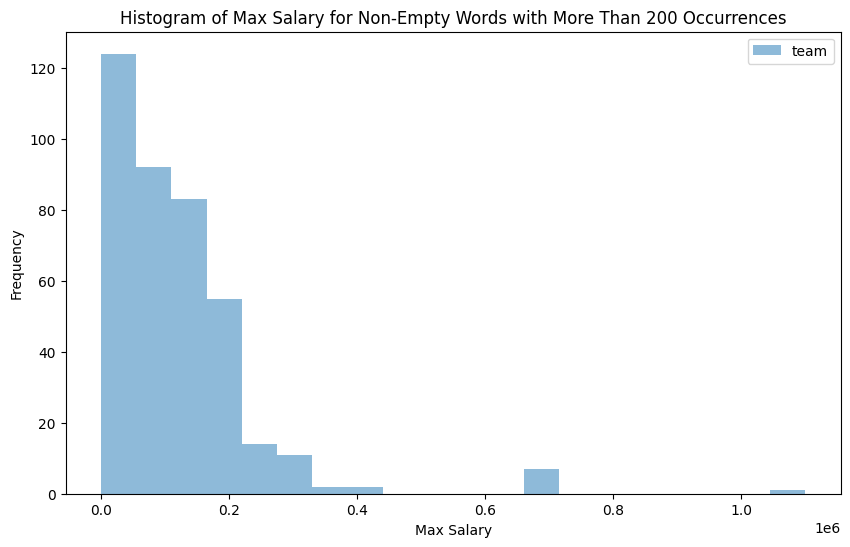

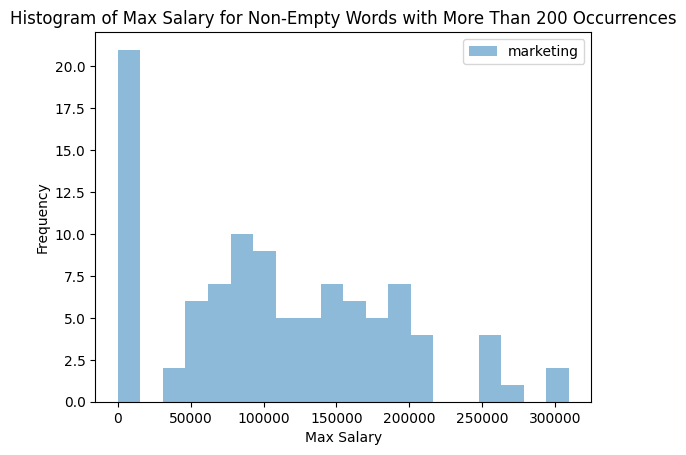

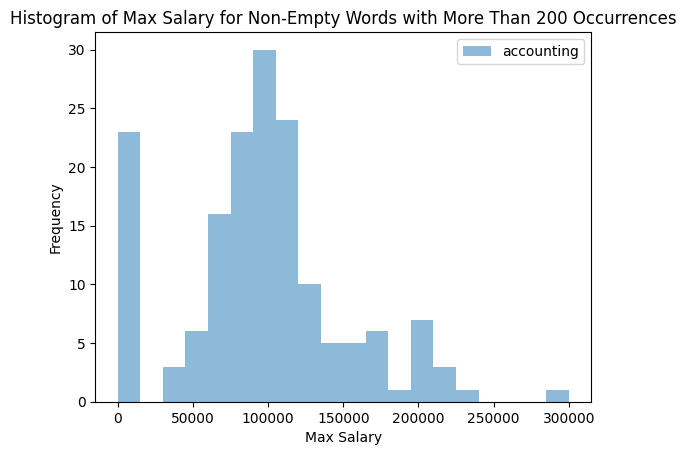

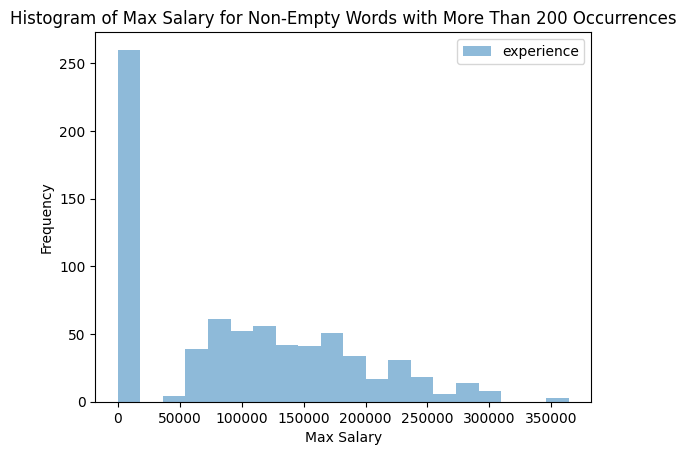

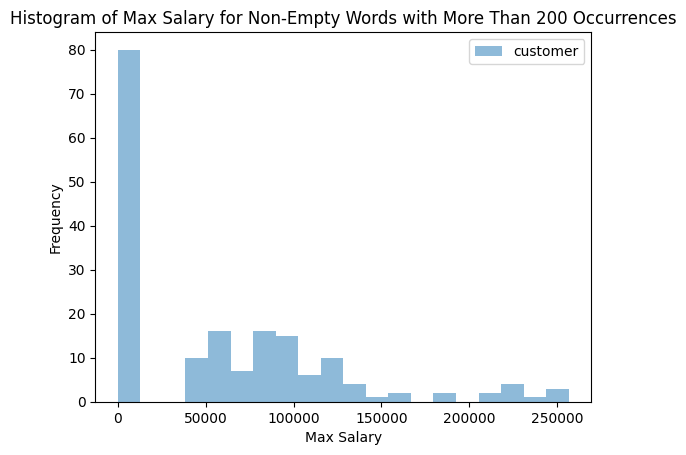

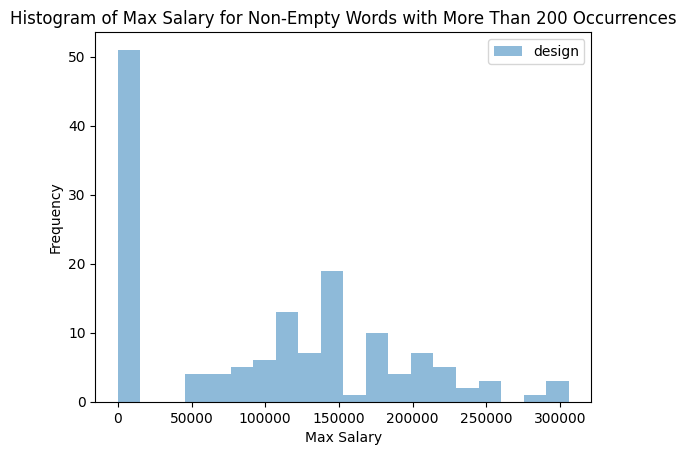

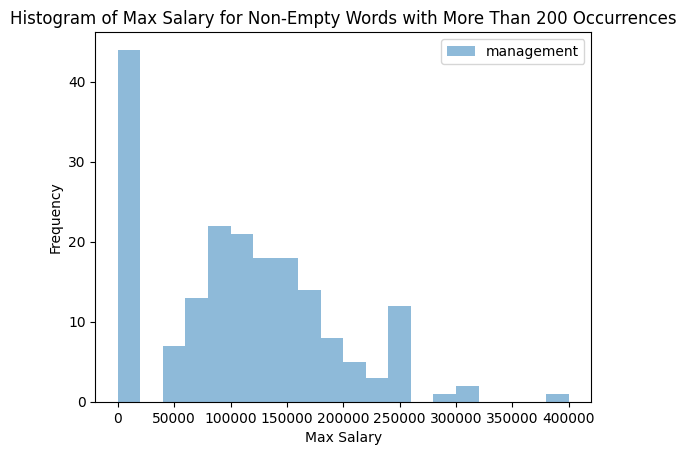

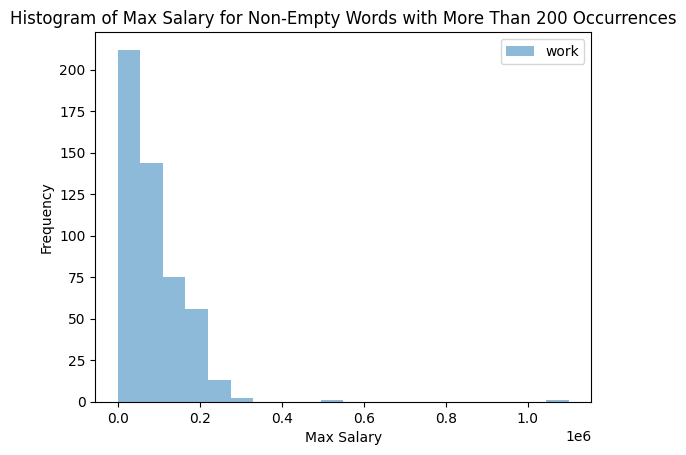

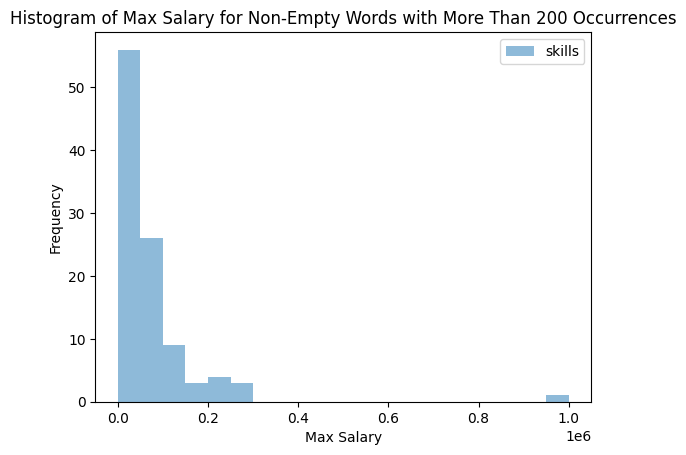

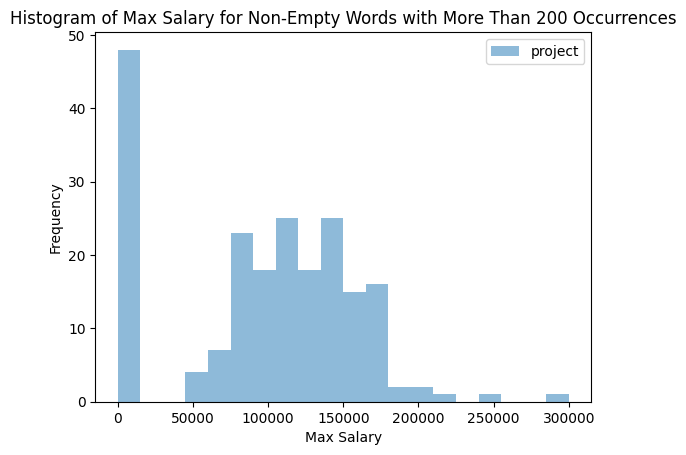

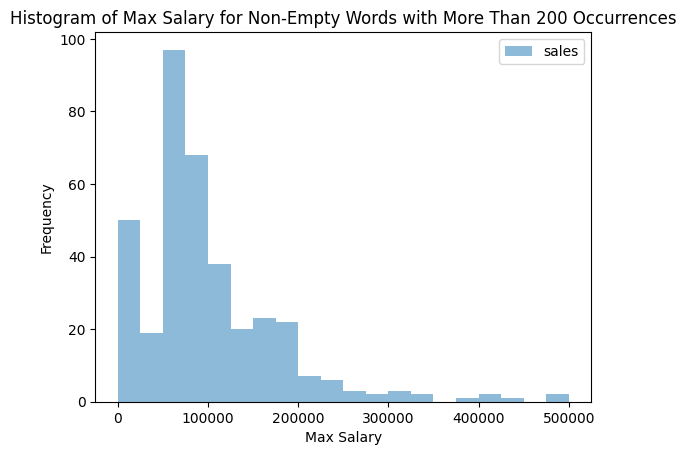

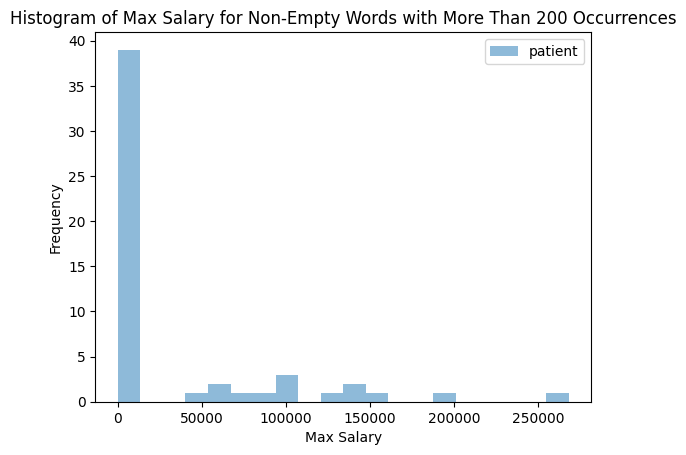

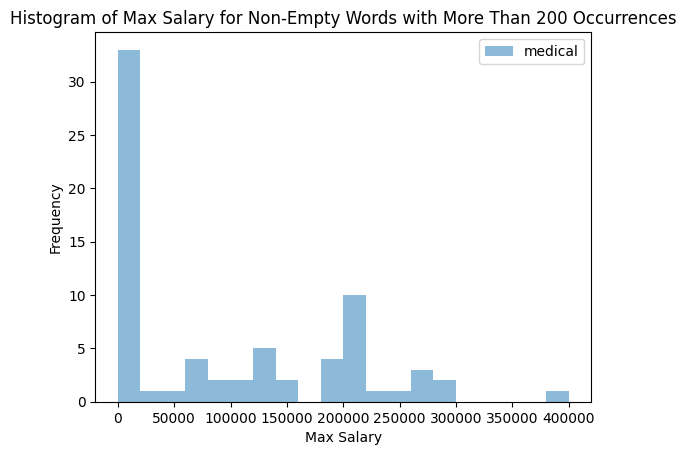

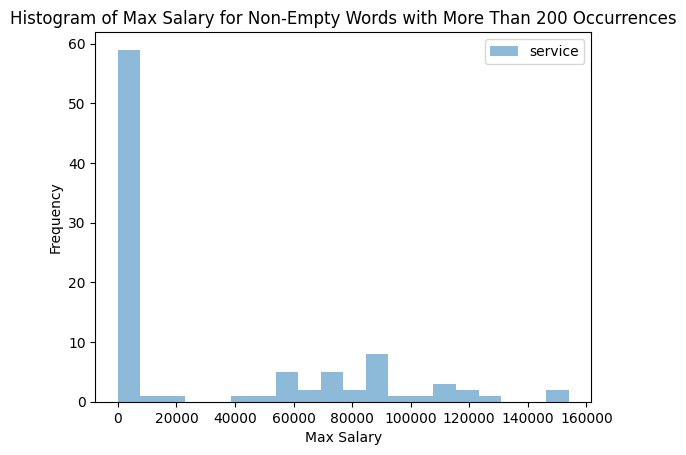

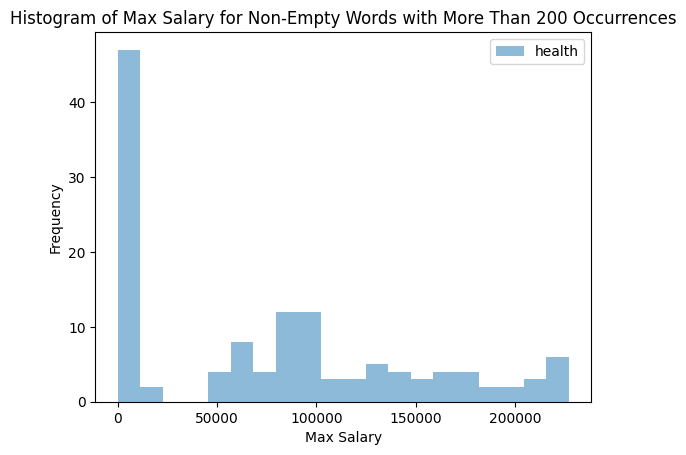

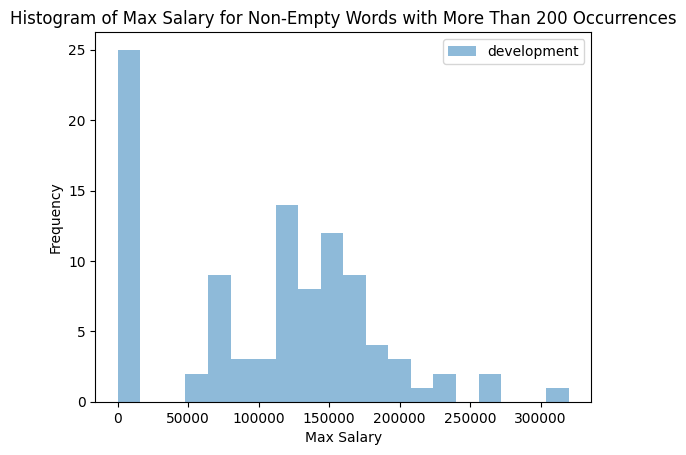

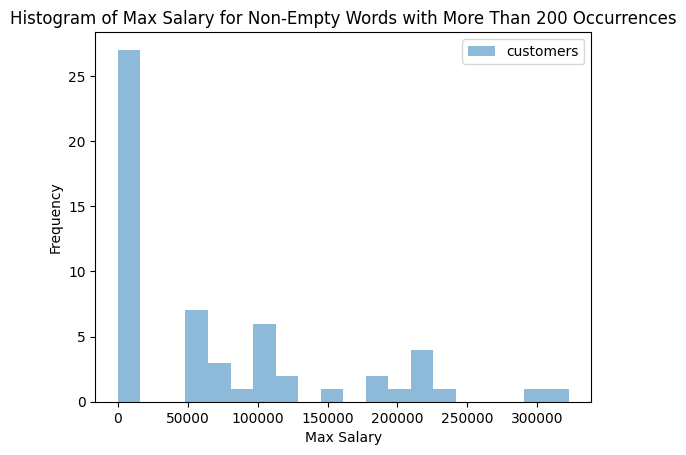

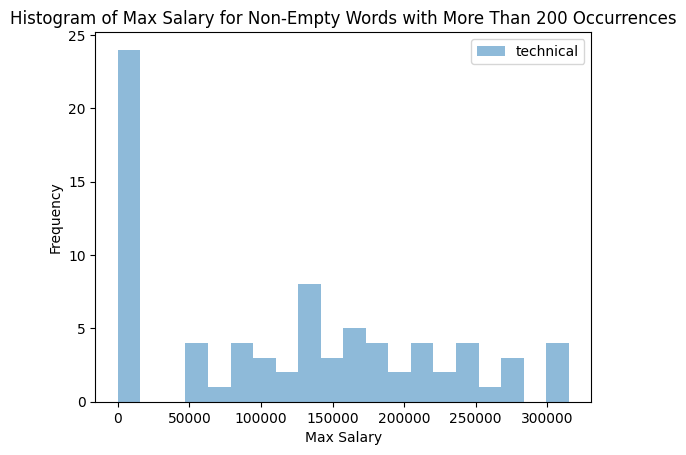

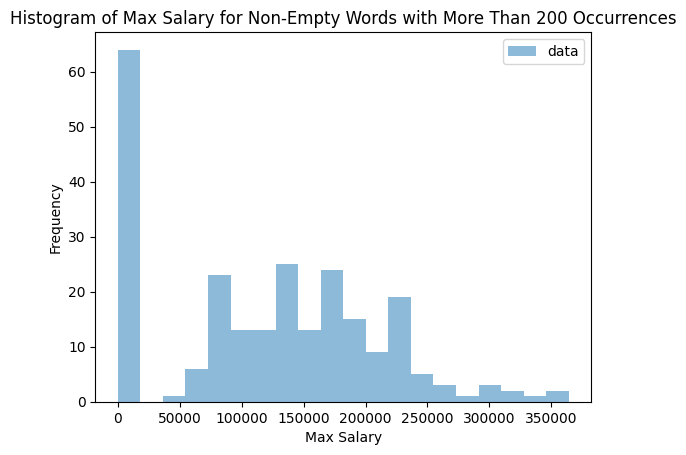

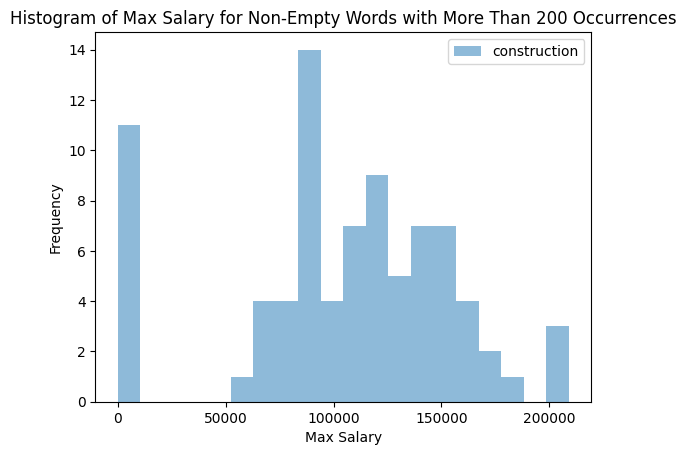

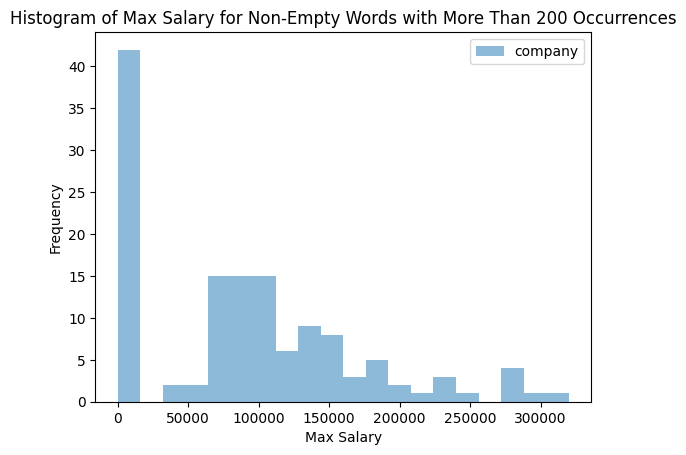

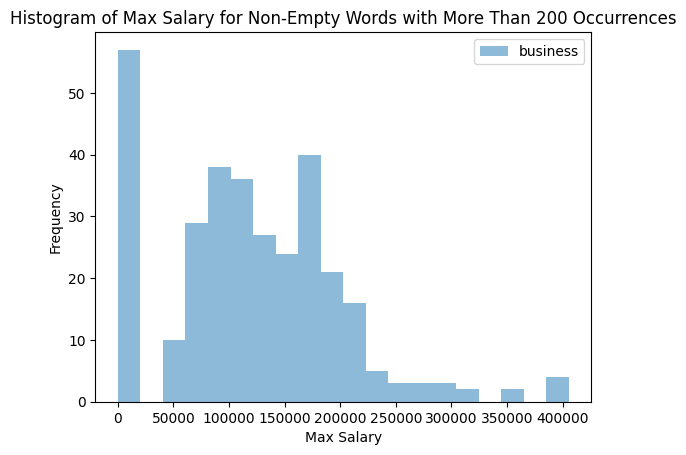

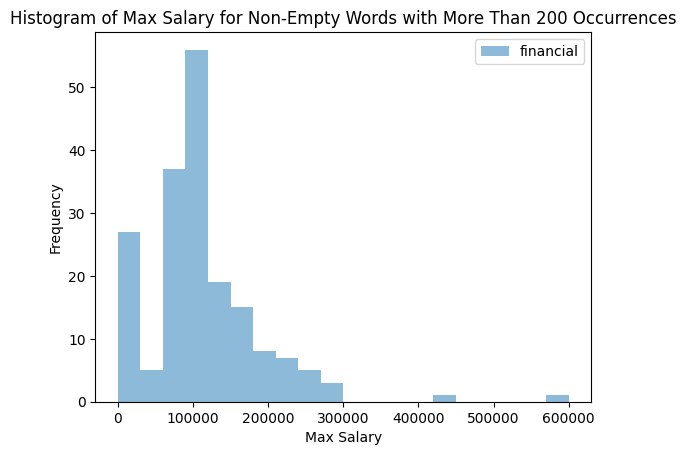

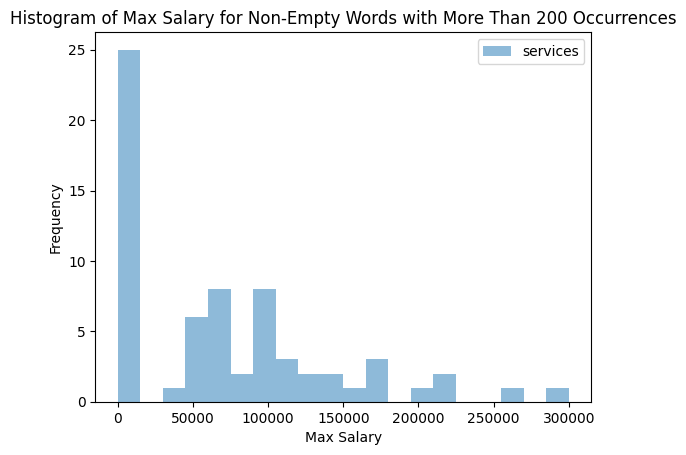

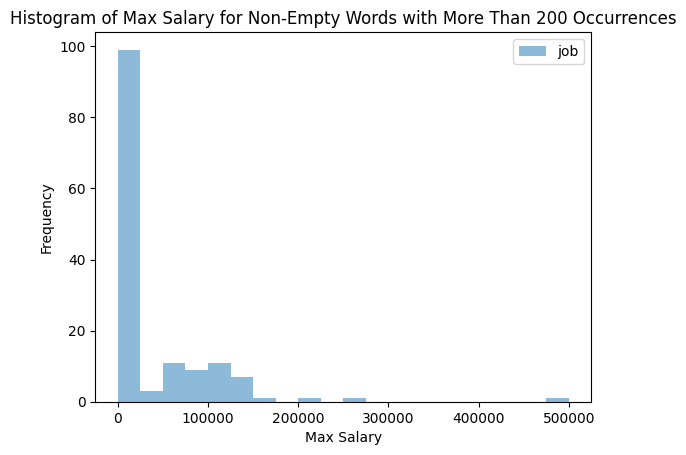

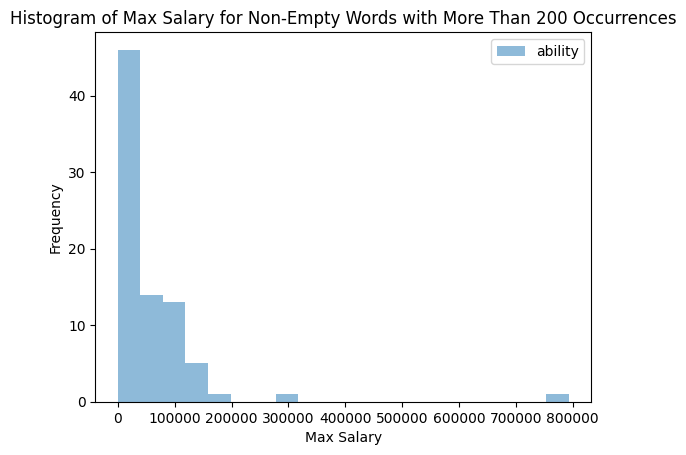

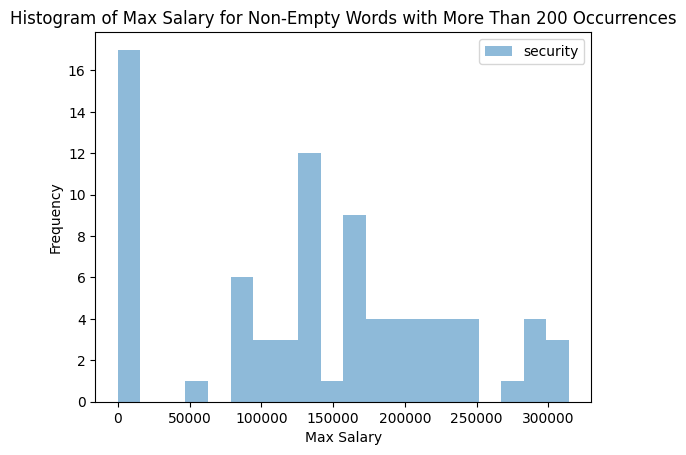

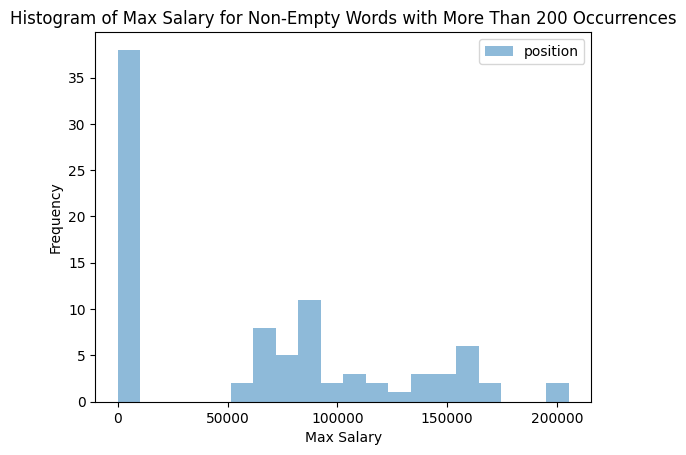

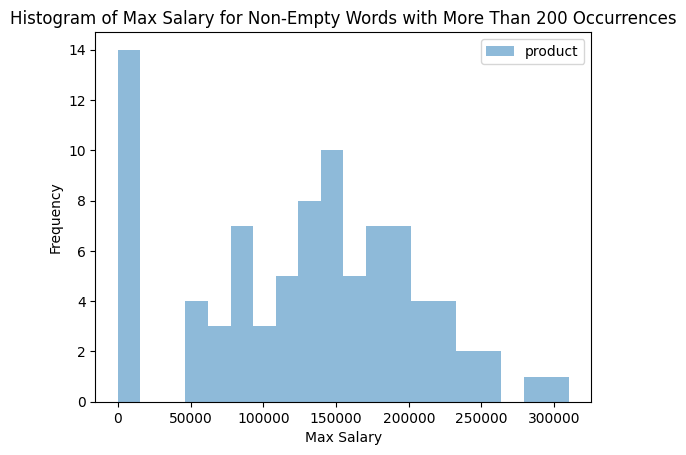

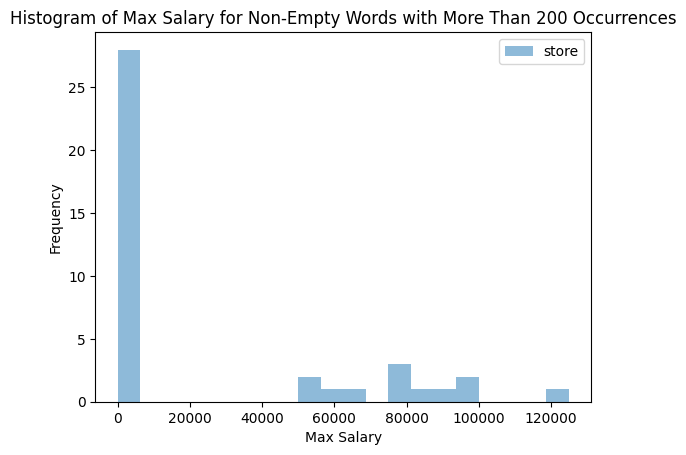

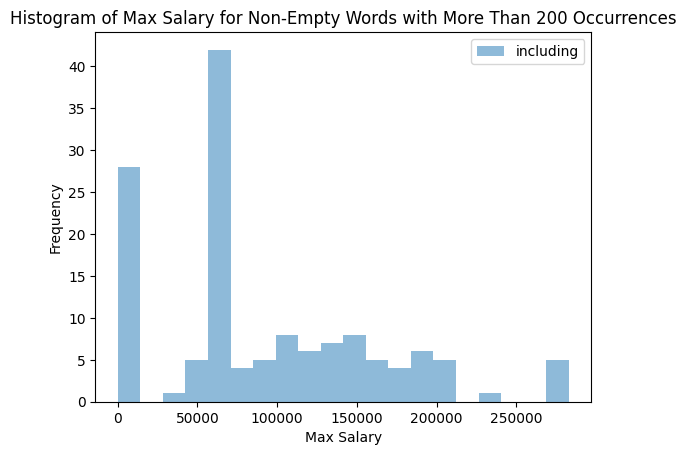

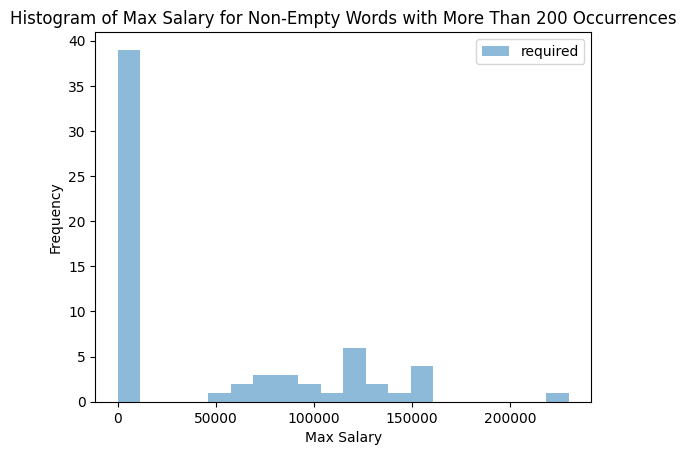

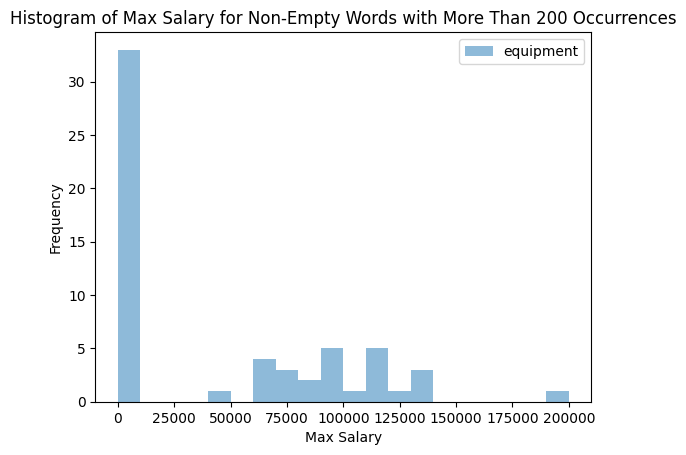

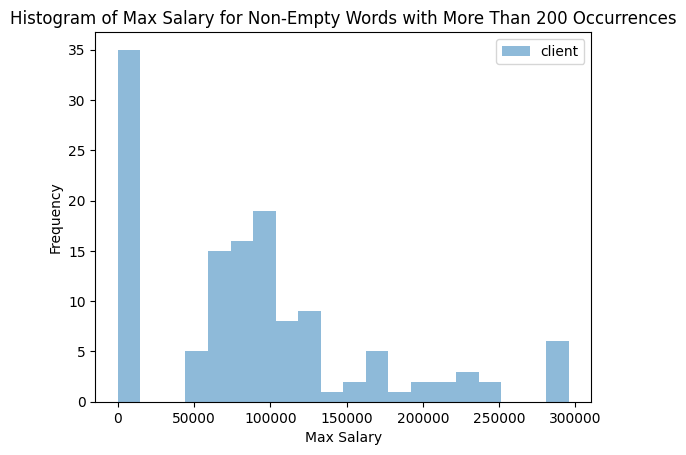

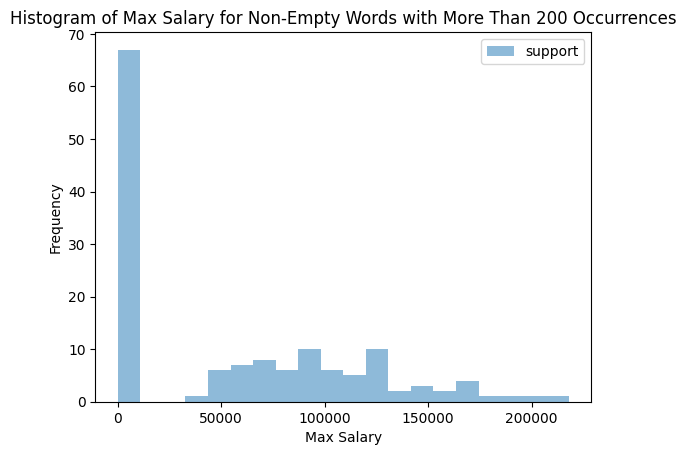

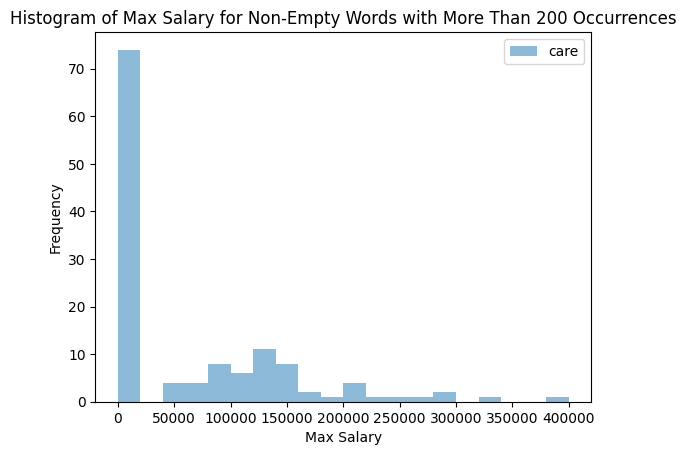

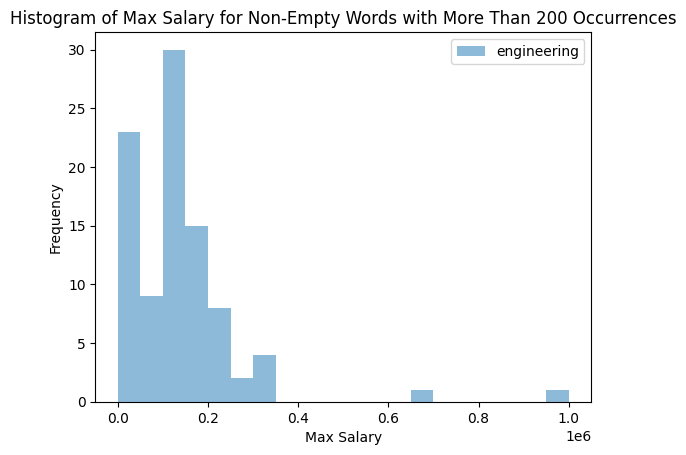

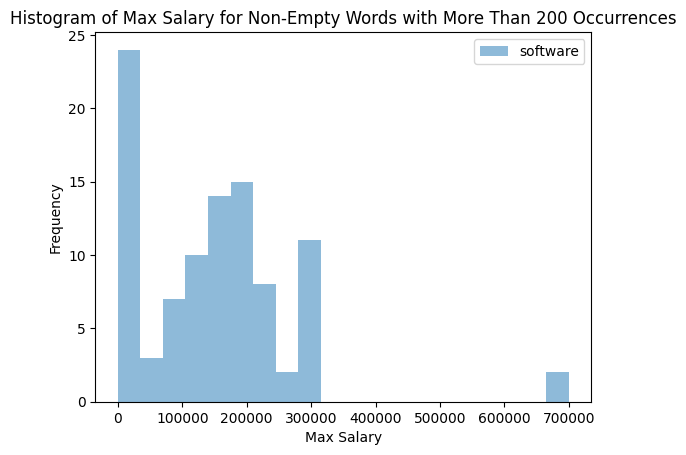

In [103]:
# Create a list of word and salary pairs for non-empty lists
word_salary_list = [(word, salary) for words, salary in zip(job_postings_data['top_descrip_words'], job_postings_data['max_salary']) for word in words if words]

# Create a dictionary to store the words and associated max_salary values
word_salary_dict = {}
for word, salary in word_salary_list:
    if word in word_salary_dict:
        word_salary_dict[word].append(salary)
    else:
        word_salary_dict[word] = [salary]

# Filter the dictionary to include only words with more than 100 occurrence
filtered_word_salary_dict = {word: salaries for word, salaries in word_salary_dict.items() if len(salaries) > 200}

# Plot a histogram of max_salary values for words with more than 1 occurrence
plt.figure(figsize=(10, 6))
for word, salaries in filtered_word_salary_dict.items():
    if word:
        plt.hist(salaries, bins=20, alpha=0.5, label=word)
        plt.xlabel('Max Salary')
        plt.ylabel('Frequency')
        plt.title('Histogram of Max Salary for Non-Empty Words with More Than 200 Occurrences')
        plt.legend()
        plt.show()

# plt.show()


In [106]:
job_postings_data['top_skill_words'] = job_postings_data['skills_desc'].apply(get_top_words)

print(job_postings_data['top_skill_words'])
# Create a list of word and salary pairs for non-empty lists


0        []
1        []
2        []
3        []
4        []
         ..
15881    []
15882    []
15883    []
15884    []
15885    []
Name: top_skill_words, Length: 15886, dtype: object


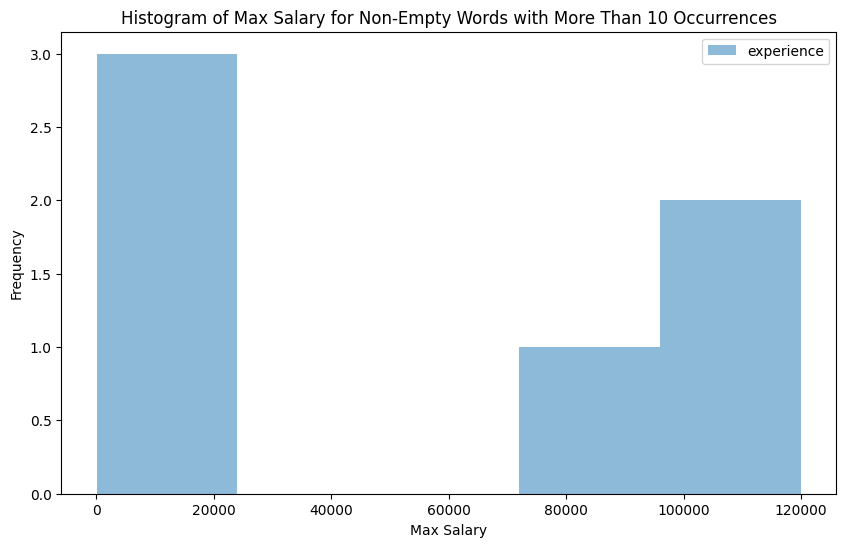

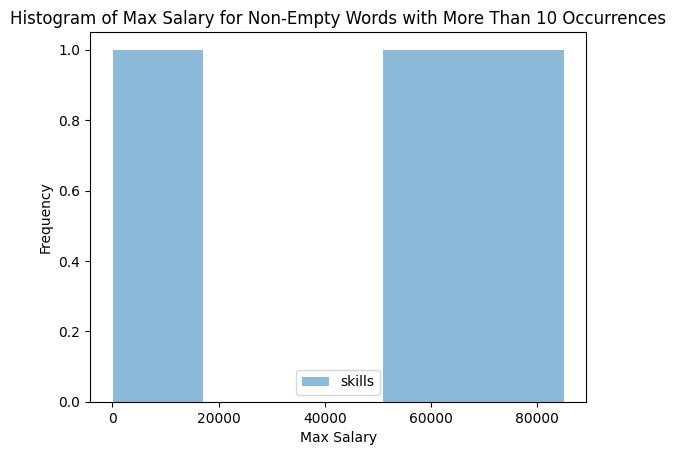

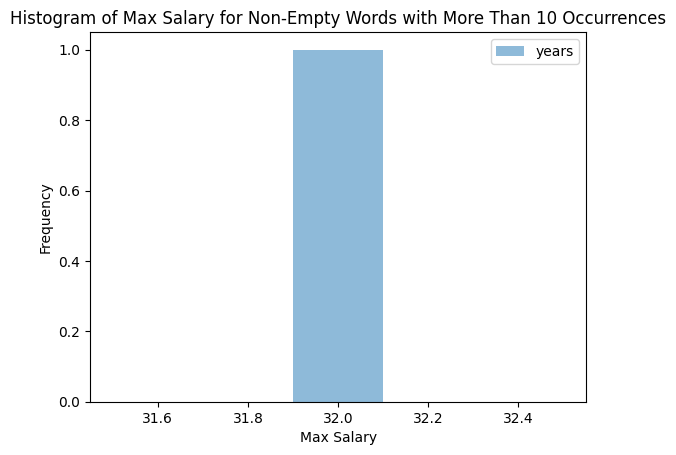

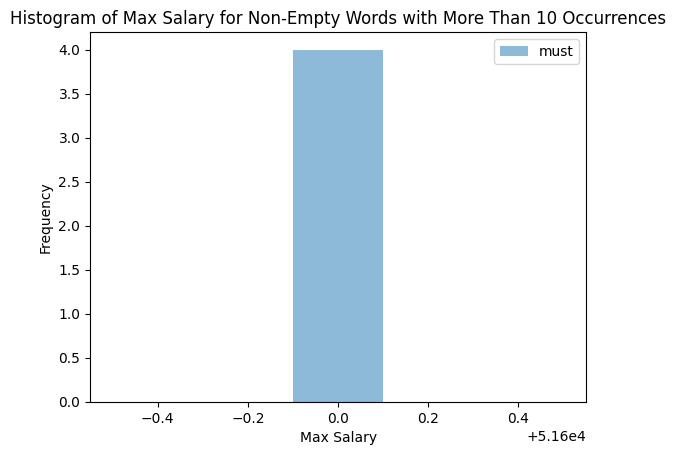

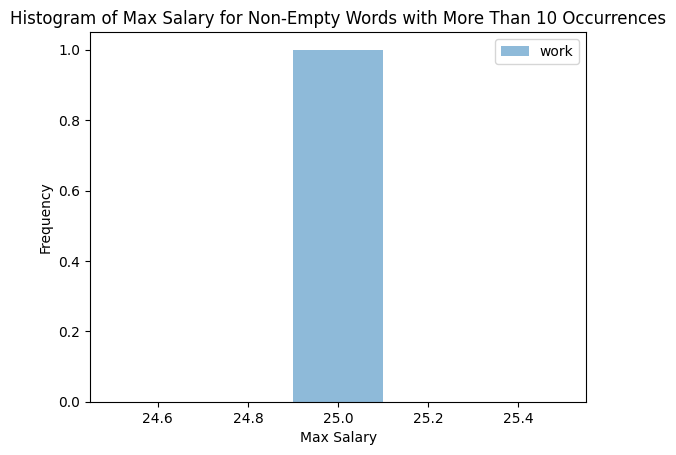

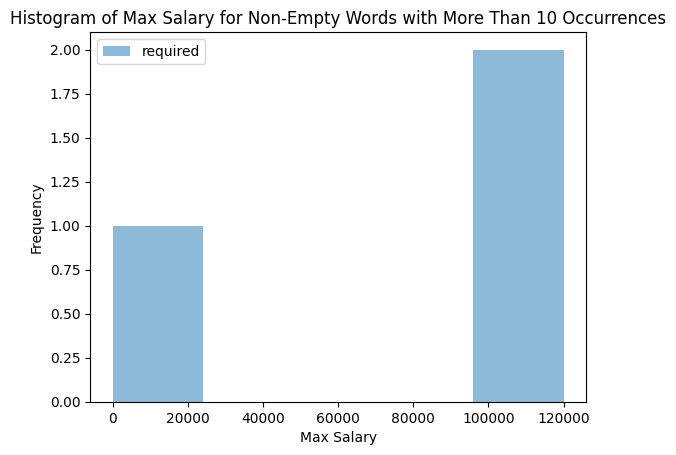

In [112]:
word_salary_list = [(word, salary) for words, salary in zip(job_postings_data['top_skill_words'], job_postings_data['max_salary']) for word in words if words]

# Create a dictionary to store the words and associated max_salary values
word_salary_dict = {}
for word, salary in word_salary_list:
    if word in word_salary_dict:
        word_salary_dict[word].append(salary)
    else:
        word_salary_dict[word] = [salary]

# Filter the dictionary to include only words with more than 100 occurrence
filtered_word_salary_dict = {word: salaries for word, salaries in word_salary_dict.items() if len(salaries) > 10}

# Plot a histogram of max_salary values for words with more than 1 occurrence
plt.figure(figsize=(10, 6))
for word, salaries in filtered_word_salary_dict.items():
    if word:
        plt.hist(salaries, bins=5, alpha=0.5, label=word)
        plt.xlabel('Max Salary')
        plt.ylabel('Frequency')
        plt.title('Histogram of Max Salary for Non-Empty Words with More Than 10 Occurrences')
        plt.legend()
        plt.show()

# plt.show()


In [82]:
# Function to get the three most common words for a given job description
def get_top_words(description):
    words = word_tokenize(description)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    word_counts = Counter(filtered_words)
    top_words = [word for word, _ in word_counts.most_common(3)]
    return top_words

# # Combine all job descriptions into a single string
# all_descriptions = ' '.join(job_postings_data['description'].astype(str))
for word in range(len(job_postings_data['description']))
top_words = get_top_words(job_postings_data['description'][0])[0:10]
print(top_words)
    
# Tokenize the text into words
stop_words = set(stopwords.words('english'))


# # Add a new column to the DataFrame with the three most common words for each description
# job_postings_data['top_words'] = job_postings_data['description'].apply(get_top_words)
# print(job_postings_data['top_words'])

['team', 'insurance', 'need']


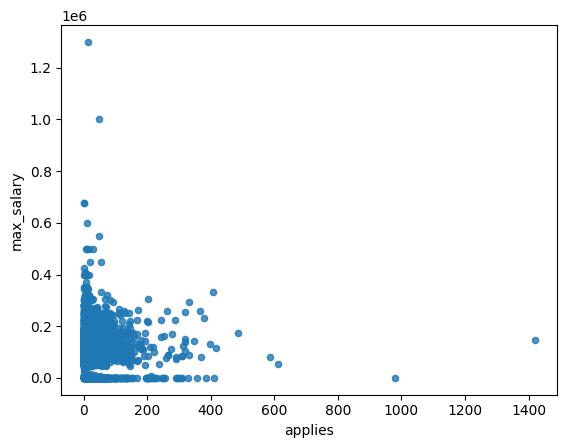

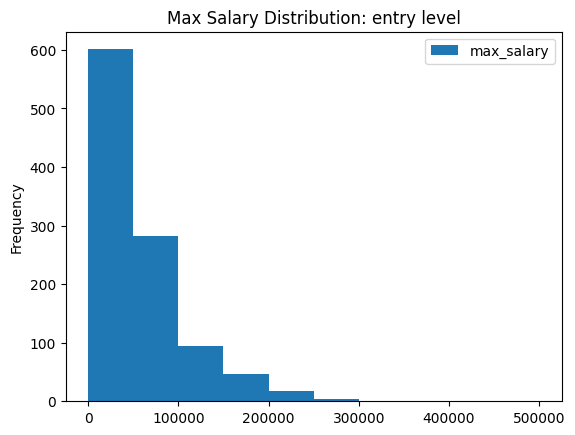

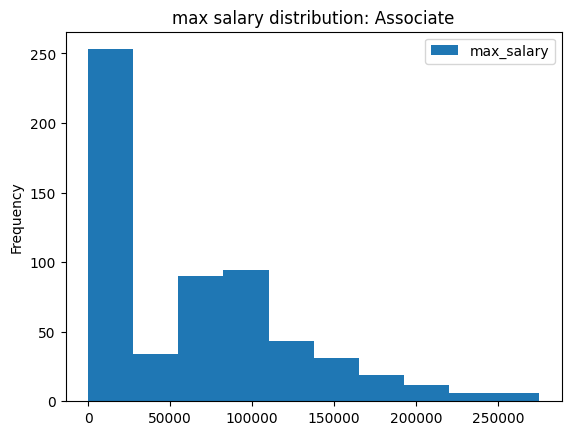

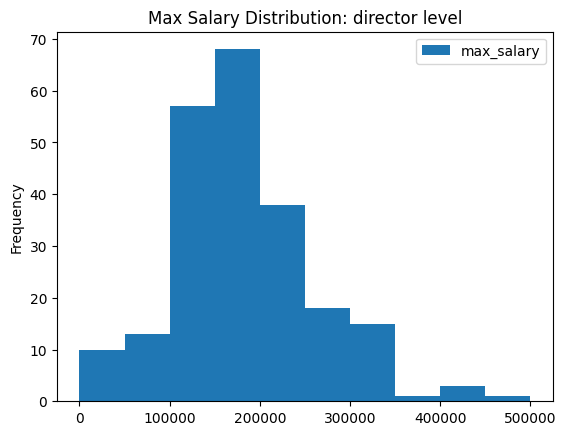

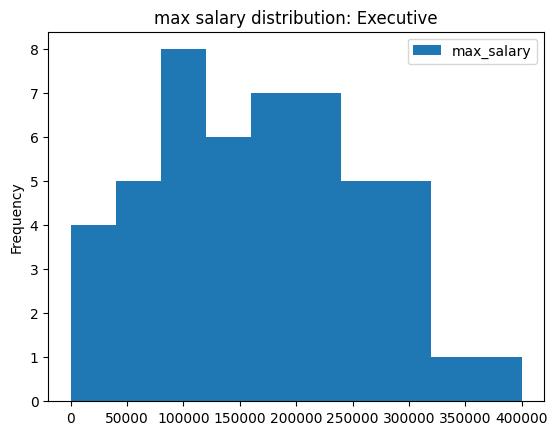

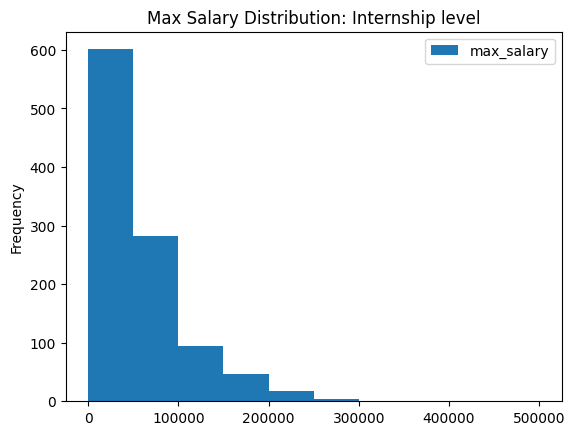

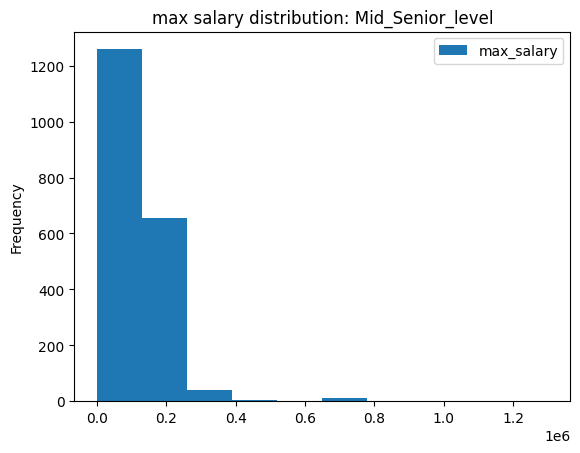

In [79]:
#Visualizations
#'job_id', 'company_id', 'title', 'description', 'max_salary',
# 'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
# 'location', 'applies', 'original_listed_time', 'remote_allowed',
# 'views', 'job_posting_url', 'application_url', 'application_type',
# 'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
# 'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
# 'compensation_type'
job_postings_data.plot(kind='scatter', y="max_salary", x="applies", alpha=.8)
# job_postings_data.plot(kind='scatter', y="max_salary", x="location", alpha=.8)

level_data = job_postings_data.groupby("formatted_experience_level")


entry_level_data = level_data.get_group("Entry level")
entry_level_data.plot(kind="hist", y="max_salary", title="Max Salary Distribution: entry level")

Associate_data = level_data.get_group("Associate")
Associate_data.plot(kind="hist", y="max_salary", title="max salary distribution: Associate")

director_data = level_data.get_group("Director")
director_data.plot(kind="hist", y="max_salary", title="Max Salary Distribution: director level")

Executive_data = level_data.get_group("Executive")
Executive_data.plot(kind="hist", y="max_salary", title="max salary distribution: Executive")

Internship_level_data = level_data.get_group("Entry level")
Internship_level_data.plot(kind="hist", y="max_salary", title="Max Salary Distribution: Internship level")

Mid_Senior_level_data = level_data.get_group("Mid-Senior level")
Mid_Senior_level_data.plot(kind="hist", y="max_salary", title="max salary distribution: Mid_Senior_level")
plt.show()


def hexbin(experience_level):
    # Group by "max_salary" and count the frequency of unique values

    grouped_df = experience_level.groupby('max_salary').size().reset_index(name='frequency')

    # Plot
    plt.scatter(grouped_df['frequency'], grouped_df['max_salary'])
    plt.ylabel('Max Salary')
    plt.xlabel('Frequency of Unique Values')
    plt.title('Plot: Frequency vs max salary')
    plt.show()
    


KeyError: 'top_skils_words'

experience level entry_level_data


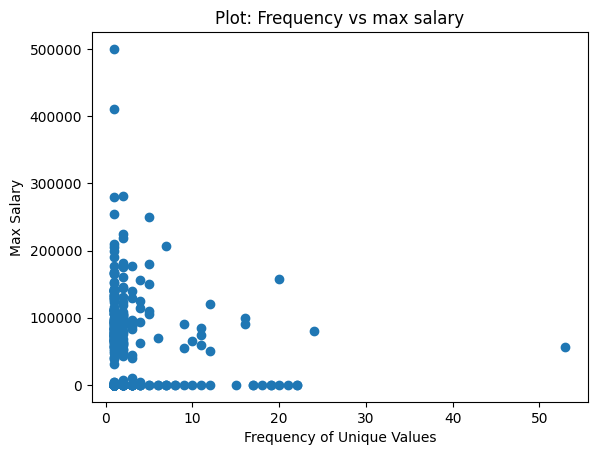

experience level Associate_data


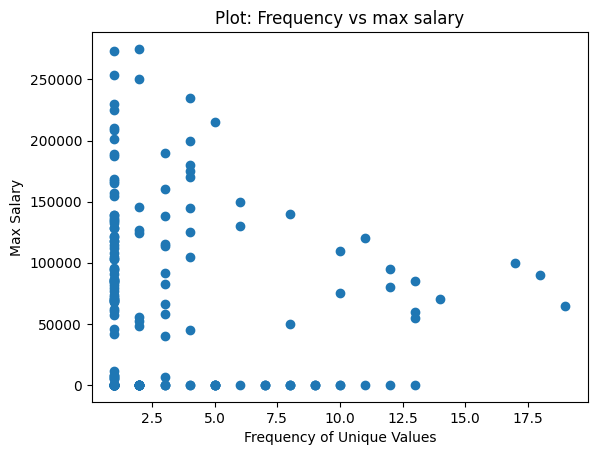

experience level Executive_data


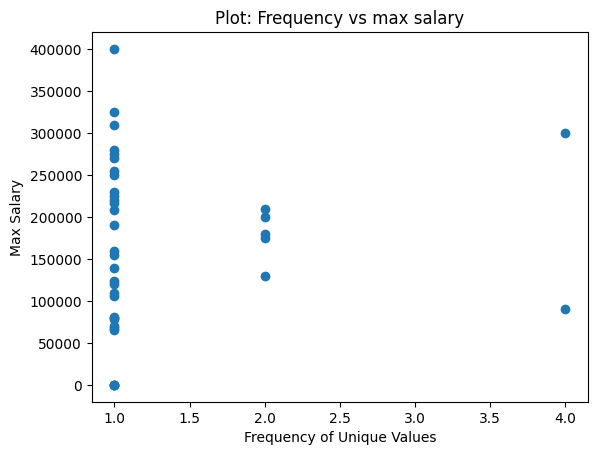

experience level Internship_level_data


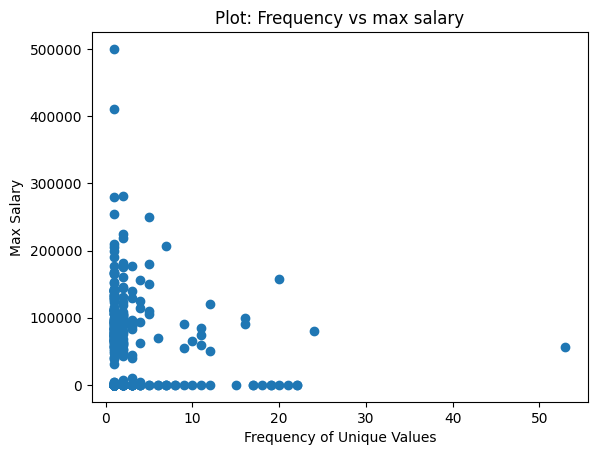

experience level Mid_Senior_level_data


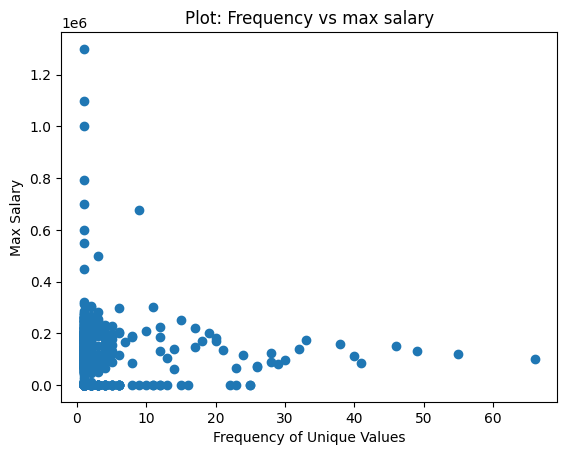

In [80]:
# experience_levels = [entry_level_data, Associate_data, Executive_data, Internship_level_data, Mid_Senior_level_data]
experience_levels = {
    'entry_level_data': entry_level_data,
    'Associate_data': Associate_data,
    'Executive_data': Executive_data,
    'Internship_level_data': Internship_level_data,
    'Mid_Senior_level_data': Mid_Senior_level_data
}
for variable_name, experience in experience_levels.items():
    print("experience level", variable_name)
    hexbin(experience)
# hexbin(_data)
# job_postings_data.plot(kind='hexbin', y="max_salary", x="applies", gridsize=2)

## **4 &ensp; Limitations**

### **4.1 &ensp; (Un)Suitability of the Data**

### **4.2 &ensp; Lack of Data**

&emsp; &nbsp; Through the data cleaning process, we learned that the missing values for the formatted experience level overlapped with those of the median salary. This created the problem that when dropping the NaN values in median salary, the formatted experience level columns disappeared, making median salary unusable in the predictions for experience level. Though we don’t know for certain, we guess that the median salary data could have improved the accuracy of our model, so it is unfortunate that this overlap occurred. 

## **5 &ensp; Conclusion**

## **6 Bibliography** 